# Explore spatial averaging on IEC canonical panel antenna

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 25/7/2021

+ FEKO data provided by Danie Ludick
+ Uses **v8** RFcalcUC module
+ This notebook uses dataframes in HDF5 files that were generated from the `make_HDF5.ipynb` notebook
+ Added analysis of Danie's body SAR rotation analysis

## Initialise

#### Load necessary python modules

In [8]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import other modules
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from tqdm import tqdm
from scipy import stats
from scipy import interpolate
from collections import namedtuple
import pandas as pd
import RFcalcUC_v9 as RFcalcUC
from matplotlib.ticker import StrMethodFormatter
pd.set_option('display.max_rows', 180)

# Set plotting environment
sn.set()

#### Set the location of the data and image directories

In [9]:
# Set the data and plot directory
import os
curdir = os.getcwd()
antdir = '../antennas/'
datadir = '../antennas/MBSpanel/data/'
plotdir = '../antennas/MBSpanel/plots/'
print(f"current directory:\n  {curdir}")
print(f"data directory:\n  {datadir}")
print(f"plot directory:\n  {plotdir}")

current directory:
  C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks
data directory:
  ../antennas/MBSpanel/data/
plot directory:
  ../antennas/MBSpanel/plots/


## Look at model metadata for the spatial averaging trials

In [10]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials

,unit,1,2
INPUT,,,
fMHz,MHz,900,
antenna,,IEC 62232 panel antenna,
Prad,W,80,
coordinate_origin,,centre of the middle feed segment,
xstart,m,0.5,
xend,m,14,
dx,m,0.1,
ystart,m,-7,
yend,m,7,


## Create the RFc object for the analyses
The class for this object is in the `RFcalcUC_v8.py` file

In [11]:
# Set trial number
trial = 1
t = trials[str(trial)]

In [39]:
# Set data and plot folders
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
print(f'{datadir = }')
print(f'{plotdir = }')

# Specify the RFc object parameters
freq = t.fMHz   # 900 MHz
power = t.Prad  # 80 W

# Field point grid
grid = dict(x=[t.xstart, t.xend, t.dx], 
            y=[t.ystart, t.yend, t.dy],
            z=[t.zstart, t.zend, t.dz])

# Antenna box dimensions (xyz extents)
xb = [0, 0.1]
yb = [-0.15, 0.15]
zb = [-1.125, 1.125]
antennabox = [xb, yb, zb]

# Create the RFc object
reload(RFcalcUC)
R = RFcalcUC.RFc(freq, power, grid, antennabox)
R

datadir = '../antennas/MBSpanel/data/'
plotdir = '../antennas/MBSpanel/plots/'


Object parameters:
  900 MHz, 80 W
  errtol = 0.15
  offset = 0.01 m
  1,169,736 grid points
  nx = 136, ny = 141, nz = 61

In [40]:
# Import the S data files for FEKO and IXUS
Sfile = datadir + f'{t.antenna_folder}.hdf5'
R.importS(Sfile)

# Display the first few records in the S dataframe
display(R.S.head())

# Print the datatitles for the S data
display(R.datatitles)
print(*R.grid.items(),sep='\n')

,x,y,z,r,phi,SE,SH,Smax,SARwb,SARwbi
0,0.5,-7.0,-3.0,7.017834,-85.914383,0.004689,0.004748,0.004748,NaN,NaN
1,0.5,-7.0,-2.9,7.017834,-85.914383,0.005296,0.005374,0.005374,NaN,NaN
2,0.5,-7.0,-2.8,7.017834,-85.914383,0.005512,0.005594,0.005594,NaN,NaN
3,0.5,-7.0,-2.7,7.017834,-85.914383,0.005286,0.005353,0.005353,NaN,NaN
4,0.5,-7.0,-2.6,7.017834,-85.914383,0.004674,0.004708,0.004708,NaN,NaN


{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)'}

('x', [0.5, 14, 0.1])
('y', [-7, 7, 0.1])
('z', [-3, 3, 0.1])


## Data checks

### Check S values against IEC 62232 validation results

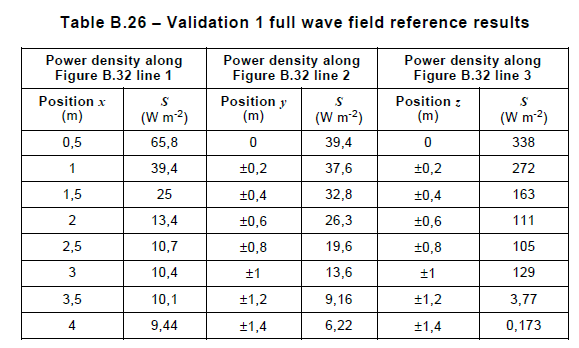

#### Check against SE

In [41]:
# Check 1
xpoints = np.arange(0.5,4.5,0.5)
mask = (R.S.x.isin(xpoints)) & (R.S.y == 0) & (R.S.z == 0)
print("Line 1")
line1 = R.S.loc[mask, ['x','SE']].round(2)
line1['IEC'] = [65.8,39.4,25,13.4,10.7,10.4,10.1,9.44]
line1['% error'] = ((line1.SE - line1.IEC) / line1.IEC * 100).round(1)
line1 = line1.reset_index(drop=True)
display(line1)

# Check 2
ypoints = np.round(np.arange(0,1.6,0.2),1)
mask = (R.S.y.isin(ypoints)) & (R.S.x == 1) & (R.S.z == 0)
print("Line 2")
line2 = R.S.loc[mask, ['y','SE']].round(1)
line2['IEC'] = [39.4,37.6,32.8,26.3,19.6,13.6,9.16,6.22]
line2['% error'] = ((line2.SE - line2.IEC) / line2.IEC * 100).round(1)
line2 = line2.reset_index(drop=True)
display(line2)

Line 1


,x,SE,IEC,% error
0,0.5,66.02,65.80,0.3
1,1.0,38.54,39.40,-2.2
2,1.5,24.41,25.00,-2.4
3,2.0,13.79,13.40,2.9
4,2.5,11.18,10.70,4.5
5,3.0,10.70,10.40,2.9
6,3.5,10.24,10.10,1.4
7,4.0,9.55,9.44,1.2


Line 2


,y,SE,IEC,% error
0,0.0,38.5,39.40,-2.3
1,0.2,36.6,37.60,-2.7
2,0.4,31.6,32.80,-3.7
3,0.6,25.2,26.30,-4.2
4,0.8,18.8,19.60,-4.1
5,1.0,13.2,13.60,-2.9
6,1.2,9.0,9.16,-1.7
7,1.4,6.3,6.22,1.3


#### Check against Smax

In [42]:
# Check 1
xpoints = np.arange(0.5,4.5,0.5)
mask = (R.S.x.isin(xpoints)) & (R.S.y == 0) & (R.S.z == 0)
print("Line 1")
line1 = R.S.loc[mask, ['x','Smax']].round(2)
line1['IEC'] = [65.8,39.4,25,13.4,10.7,10.4,10.1,9.44]
line1['% error'] = ((line1.Smax - line1.IEC) / line1.IEC * 100).round(1)
line1 = line1.reset_index(drop=True)
display(line1)

# Check 2
ypoints = np.round(np.arange(0,1.6,0.2),1)
mask = (R.S.y.isin(ypoints)) & (R.S.x == 1) & (R.S.z == 0)
print("Line 2")
line2 = R.S.loc[mask, ['y','Smax']].round(1)
line2['IEC'] = [39.4,37.6,32.8,26.3,19.6,13.6,9.16,6.22]
line2['% error'] = ((line2.Smax - line2.IEC) / line2.IEC * 100).round(1)
line2 = line2.reset_index(drop=True)
display(line2)

Line 1


,x,Smax,IEC,% error
0,0.5,67.49,65.80,2.6
1,1.0,40.08,39.40,1.7
2,1.5,25.01,25.00,0.0
3,2.0,13.79,13.40,2.9
4,2.5,11.18,10.70,4.5
5,3.0,10.73,10.40,3.2
6,3.5,10.35,10.10,2.5
7,4.0,9.66,9.44,2.3


Line 2


,y,Smax,IEC,% error
0,0.0,40.1,39.40,1.8
1,0.2,38.3,37.60,1.9
2,0.4,33.5,32.80,2.1
3,0.6,26.8,26.30,1.9
4,0.8,19.9,19.60,1.5
5,1.0,13.7,13.60,0.7
6,1.2,9.1,9.16,-0.7
7,1.4,6.3,6.22,1.3


In [24]:
# Check 1
xpoints = np.arange(0.5,4.5,0.5)
mask = (R.S.x.isin(xpoints)) & (R.S.y == 0) & (R.S.z == 0)
print("Line 1")
line1 = R.S.loc[mask, ['x','Smax']].round(1)
display(line1)
# Check 2
ypoints = np.round(np.arange(0,1.6,0.2),1)
mask = (R.S.y.isin(ypoints)) & (R.S.x == 1) & (R.S.z == 0)
print("Line 2")
line2 = R.S.loc[mask, ['y','Smax']].round(1)
display(line2)

Line 1


,x,Smax
4300,0.5,67.5
47305,1.0,40.1
90310,1.5,25.0
133315,2.0,13.8
176320,2.5,11.2
219325,3.0,10.7
262330,3.5,10.3
305335,4.0,9.7


Line 2


,y,Smax
47305,0.0,40.1
47427,0.2,38.3
47549,0.4,33.5
47671,0.6,26.8
47793,0.8,19.9
47915,1.0,13.7
48037,1.2,9.1
48159,1.4,6.3


<font color='blue'>FEKO values line up OK with IEC 62232 validation values</font>

### Show S and SAR grids

In [9]:
R.showgrids(hman=1.57,axv=(True,False,True))

## View public and occ compliance zones

In [43]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.ExclusionZone(
    data=["Smax", "Smax"],
    power=[200, 200],
    color=["gold", "red"],
    alpha=[0.5, 0.8],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title="RPS S-1 public and occupational exclusion zones for FEKO Smax data",
    figsize=(1200,800)
)

dat='Smax', con=1.8
dat='Smax', con=9.0
power = 80, plotpower = 200, setting = public, limit = 4.5 W/m², contour level = 1.800
power = 80, plotpower = 200, setting = occupational, limit = 22.5 W/m², contour level = 9.000


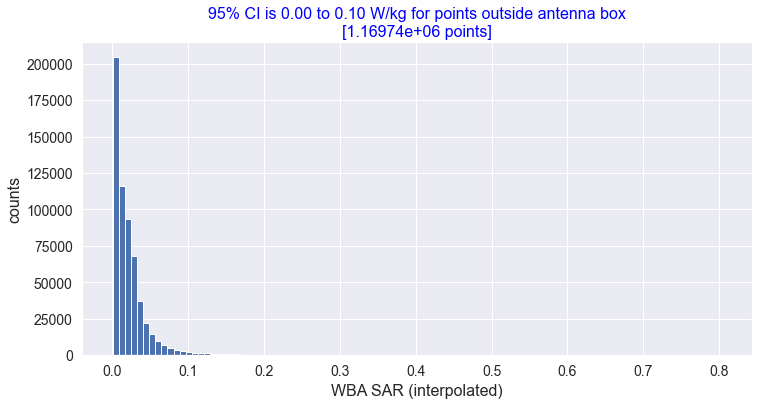

In [25]:
R.hist(data='SARwbi', bins=100)

## Spatially averaged fields

#### Create some new S columns for vertical spatial averaging
c is the convolution vector applied to z columns of points for each (x,y) group

In [26]:
def conv_vector(l, dl, m):
    '''Create a convolution vector
        l = length of convolution vector (m)
       dl = increment spacing between points in convolution vector (m)
        m = number of averaging points in convolution vector'''

    n = int(round(l/dl)) + 1  # number of points in convolution vector'''
    c = np.ones(n)            # convolution vector
    ix = np.arange(n)         # index of convolution vector
    dix = (n-1)/(m-1)         # index spacing between convolution averaging points

    assert round(l/dl,0) == round(l/dl,1), f'dl ({dl}) does not divide equally into l ({l})'
    assert type(m) == int, f'm ({m}) must be an integer'
    assert (n-1) % (m-1) == 0, f'm ({m}) does not distribute evenly across number of convolution points ({n})'

    c[(ix % dix) != 0] = 0
    c = c/m

    assert np.isclose(sum(c), 1, rtol=1e-08), f'sum of c ({sum(c)}) does not add up to 1'
    
    return c

In [46]:
# 2m vertical average curves
l, dl = 2, 0.1
for m in [21]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")  


21 points: sum[0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048] = 1.0000000000000004
creating SE-2m-21 spatial average of SE
creating Smax-2m-21 spatial average of Smax


In [44]:
# 1.6m vertical average curves
l, dl = 1.6, 0.1
for m in [17,5,3]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")  


17 points: sum[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059] = 1.0
creating SE-1.6m-17 spatial average of SE
creating Smax-1.6m-17 spatial average of Smax

 5 points: sum[0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2] = 1.0
creating SE-1.6m-5 spatial average of SE
creating Smax-1.6m-5 spatial average of Smax

 3 points: sum[0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333] = 1.0
creating SE-1.6m-3 spatial average of SE
creating Smax-1.6m-3 spatial average of Smax


In [45]:
# 1.5m vertical average curves
l, dl = 1.5, 0.1
for m in [4,6,16]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")  


 4 points: sum[0.25, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.25] = 1.0
creating SE-1.5m-4 spatial average of SE
creating Smax-1.5m-4 spatial average of Smax

 6 points: sum[0.167, 0.0, 0.0, 0.167, 0.0, 0.0, 0.167, 0.0, 0.0, 0.167, 0.0, 0.0, 0.167, 0.0, 0.0, 0.167] = 0.9999999999999999
creating SE-1.5m-6 spatial average of SE
creating Smax-1.5m-6 spatial average of Smax

16 points: sum[0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062] = 1.0
creating SE-1.5m-16 spatial average of SE
creating Smax-1.5m-16 spatial average of Smax


In [30]:
# 1.4m vertical average curves
l, dl = 1.4, 0.1
for m in [8,15]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")  


 8 points: sum[0.125, 0.0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.0, 0.125] = 1.0
creating SE-1.4m-8 spatial average of SE
creating Smax-1.4m-8 spatial average of Smax

15 points: sum[0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067] = 0.9999999999999999
creating SE-1.4m-15 spatial average of SE
creating Smax-1.4m-15 spatial average of Smax


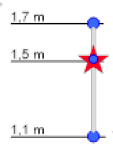

In [31]:
# IEC 62232 spatial averaging scheme (3pts over 1.7m)
c = np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1]) / 3
print(f'{len(c) = } points: sum{list(c.round(3))} = {sum(c)}')
R.spatavg(f"SE-IEC-1.7m-3", "SE", c, title=f"FEKO SE levels (IEC 3pt scheme over 1.7m)")
R.spatavg(f"Smax-IEC-1.7m-3", "Smax", c, title=f"FEKO Smax levels (IEC 3pt scheme over 1.7m)")

# IEC 62232 spatial averaging scheme (3pts over 0.6m)
c = np.array([1,0,0,0,1,0,1,0,0]) / 3
print(f'{len(c) = } points: sum{list(c.round(3))} = {sum(c)}')
R.spatavg(f"SE-IEC-0.6m-3", "SE", c, title=f"FEKO SE levels (IEC 3pt scheme over 0.6m)")
R.spatavg(f"Smax-IEC-0.6m-3", "Smax", c, title=f"FEKO Smax levels (IEC 3pt scheme over 0.6m)")

len(c) = 18 points: sum[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.333, 0.0, 0.333] = 1.0
creating SE-IEC-1.7m-3 spatial average of SE
creating Smax-IEC-1.7m-3 spatial average of Smax
len(c) = 9 points: sum[0.333, 0.0, 0.0, 0.0, 0.333, 0.0, 0.333, 0.0, 0.0] = 1.0
creating SE-IEC-0.6m-3 spatial average of SE
creating Smax-IEC-0.6m-3 spatial average of Smax


In [47]:
R.datatitles

{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)',
 'SE-1.6m-17': 'FEKO SE levels (17 points averaged over 1.6m)',
 'Smax-1.6m-17': 'FEKO Smax levels (17 points averaged over 1.6m)',
 'SE-1.6m-5': 'FEKO SE levels (5 points averaged over 1.6m)',
 'Smax-1.6m-5': 'FEKO Smax levels (5 points averaged over 1.6m)',
 'SE-1.6m-3': 'FEKO SE levels (3 points averaged over 1.6m)',
 'Smax-1.6m-3': 'FEKO Smax levels (3 points averaged over 1.6m)',
 'SE-1.5m-4': 'FEKO SE levels (4 points averaged over 1.5m)',
 'Smax-1.5m-4': 'FEKO Smax levels (4 points averaged over 1.5m)',
 'SE-1.5m-6': 'FEKO SE levels (6 points averaged over 1.5m)',
 'Smax-1.5m-6': 'FEKO Smax levels (6 points averaged over 1.5m)',
 'SE-1.5m-16': 'FEKO SE levels (16 points averaged over 1.5m)',
 'Smax-1.5m-16': 'FEKO Smax levels (16 points averaged over 1.5m)',
 'SE-2m-21': 'FEKO SE levels (21 points averaged over 2m)',
 'Smax-2

#### Effect of field uniformity on spatially averaged compliance zones

In [18]:
# Point values v 1.6m 17 pt spatial average at low power
data = ["Smax", "Smax-1.6m-17"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[20] * n,
    color=["white", "blue"],
    alpha=[0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Point spatial vs 1.6m 17 pt spatial average at low power",
    axv = (True,False,False)
)

dat='Smax', con=18.0
dat='Smax-1.6m-17', con=18.0
power = 80, plotpower = 20, setting = public, limit = 4.5 W/m², contour level = 18.000
power = 80, plotpower = 20, setting = public, limit = 4.5 W/m², contour level = 18.000


In [21]:
# Point values v 1.6m 17 pt spatial average at high power
data = ["Smax", "Smax-1.6m-17"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[200] * n,
    color=["white", "blue"],
    alpha=[0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Point spatial vs 1.6m 17 pt spatial average at high power",
    axv = (True,False,False)
)

dat='Smax', con=1.8
dat='Smax-1.6m-17', con=1.8
power = 80, plotpower = 200, setting = public, limit = 4.5 W/m², contour level = 1.800
power = 80, plotpower = 200, setting = public, limit = 4.5 W/m², contour level = 1.800


#### Effect of vertical averaging length on spatially average compliance zones

In [24]:
# Point values v 1.6m 17 pt spatial average at low power
data = ["Smax", "Smax-1.5m-16", "Smax-2m-21"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[200] * n,
    color=["white", "blue", "red"],
    alpha=[0.5]*n,
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Point spatial vs 1.5m and 2m spatial averages",
    axv = (True,False,False)
)

dat='Smax', con=1.8
dat='Smax-1.5m-16', con=1.8
dat='Smax-2m-21', con=1.8
power = 80, plotpower = 200, setting = public, limit = 4.5 W/m², contour level = 1.800
power = 80, plotpower = 200, setting = public, limit = 4.5 W/m², contour level = 1.800
power = 80, plotpower = 200, setting = public, limit = 4.5 W/m², contour level = 1.800


#### IEC spatial averaging schemes

In [27]:
# Point spatial vs values v 1.7m IEC spatial average (3 points)
data = ["Smax", "Smax-IEC-1.7m-3"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[180] * n,
    color=["white", "blue"],
    alpha=[0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Point spatial vs 1.7m IEC 62232 3pt spatial average",
    axv = (True,False,False)
)

dat='Smax', con=2.0
dat='Smax-IEC-1.7m-3', con=2.0
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000


In [59]:
# Point values v 1.5m IEC spatial average (6 points)
data = ["Smax", "Smax-1.5m-6"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[180] * n,
    color=["white", "blue"],
    alpha=[0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Point spatial vs 1.7m IEC 62232 3pt spatial average",
    axv = (True,False,False)
)

dat='Smax', con=2.0
dat='Smax-1.5m-6', con=2.0
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000


#### Compare exclusion zones for 1.6m spatial averaging lengths
+ 17 points - 1.6m at 0.1m intervals (blue)
+  5 points - 1.6m at 0.4m intervals (magenta
+  3 points - 1.6m at 0.8m intervals (orange)

In [28]:
# Point values v 0.6m spatial average (3 points)
data = ["Smax", "Smax-IEC-0.6m-3"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[180] * n,
    color=["white", "blue"],
    alpha=[0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Point spatial vs 0.6m IEC 62232 3pt spatial average",
    axv = (True,False,False)
)

dat='Smax', con=2.0
dat='Smax-IEC-0.6m-3', con=2.0
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000


In [12]:
# Point values v 1.6m spatial average (17 points)
data = ["Smax", "Smax-1.6m-17"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[180] * n,
    color=["white", "blue"],
    alpha=[0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Point spatial vs 1.6m 17pt spatial average",
    axv = (True,False,False)
)

dat='Smax', con=2.0
dat='Smax-1.6m-17', con=2.0
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000


In [25]:
# Compare effect of different numbers of spatial averaging points over 1.6m
data = ["Smax","Smax-1.6m-17", "Smax-1.6m-5", "Smax-1.6m-3"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[180] * n,
    color=["white","blue", "green", "magenta","orange"],
    alpha=[0.5,0.5,0.5,0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Compare effect of different no. of points for 1.6m spatial average",
)

dat='Smax', con=2.0
dat='Smax-1.6m-17', con=2.0
dat='Smax-1.6m-5', con=2.0
dat='Smax-1.6m-3', con=2.0
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000
power = 80, plotpower = 180, setting = public, limit = 4.5 W/m², contour level = 2.000


In [52]:
# Compare point spatial value with spatial average (5 points) for RPS S-1 WB limits
data = ["Smax","Smax-1.5m-6"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[200] * n,
    color=["white","magenta"],
    alpha=[0.6,0.4],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Compare point WB with 1.6m 5pt spatial average",
)

power = 80, plotpower = 200, setting = public, limit = 4.5, contour level = 1.800
power = 80, plotpower = 200, setting = public, limit = 4.5, contour level = 1.800


In [53]:
# Compare RPS S-1 point WB, 1.6m 5pt spatial average WB, & point local
data = ["Smax","Smax-1.6m-5","Smax"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[90] * n,
    color=["white","green","orange"],
    alpha=[0.5] * n,
    setting=["public"] * n,
    standard=["RPS S-1 WB","RPS S-1 WB","RPS S-1 local"],
    title="Compare RPS S-1 point spatial WB, 1.6m 5pt spatial average WB, & point spatial local",
    hman=1.6,
    xyzman=(-1,0,0),
    axv=(False,False,False),
    figsize=(1200,600),
)

power = 80, plotpower = 90, setting = public, limit = 4.5, contour level = 4.000
power = 80, plotpower = 90, setting = public, limit = 4.5, contour level = 4.000
power = 80, plotpower = 90, setting = public, limit = 20.1, contour level = 17.903


In [50]:
# Compare RPS S-1 1.6m 5pt spatial average WB, & point local
data = ["Smax-1.6m-5","Smax"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[180] * n,
    color=["green","blue"],
    alpha=[0.5, 0.6],
    setting=["public"] * n,
    standard=["RPS S-1 WB","RPS S-1 local"],
    title="Compare RPS S-1 1.6m 5pt spatial average WB & peak spatial local",
    hman=1.6,
    xyzman=(-1,0,0),
    axv=(False,False,False),
    figsize=(1200,600),
)

power = 80, plotpower = 180, setting = public, limit = 4.5, contour level = 2.000
power = 80, plotpower = 180, setting = public, limit = 20.1, contour level = 8.951


In [33]:
# Compare 1.6m 17pt and 2m 21pt spatial average WB
data = ["Smax","Smax-1.6m-17","Smax-2m-21"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[180] * n,
    color=["white","green","blue"],
    alpha=[0.5] * n,
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Compare [17pt 1.6m] with [21 pt 2m] spatial average for RPS S-1 WB limit",
    hman=1.6,
    axv=(False,False,False),
    figsize=(1200,600)
)

power = 200, plotpower = 90, setting = public, limit = 4.5, contour level = 10.000
power = 200, plotpower = 90, setting = public, limit = 4.5, contour level = 10.000
power = 200, plotpower = 90, setting = public, limit = 4.5, contour level = 10.000


In [16]:
# Compare 1.6m 5pt and 2m 5pt spatial average WB
data = ["Smax","Smax-1.6m-5","Smax-2m-5"]
n = len(data)
R.ExclusionZone(
    data=data,
    power=[180] * n,
    color=["white","green","blue"],
    alpha=[0.5] * n,
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Compare [5pt 1.6m] with [5pt 2m] spatial average for RPS S-1 WB limit",
    hman=1.6,
    axv=(False,False,False),
    figsize=(1200,600,)
)

power = 200, plotpower = 180, setting = public, limit = 4.5, contour level = 5.000
power = 200, plotpower = 180, setting = public, limit = 4.5, contour level = 5.000
power = 200, plotpower = 180, setting = public, limit = 4.5, contour level = 5.000


#### Compare SAR and spatial average S compliance zones

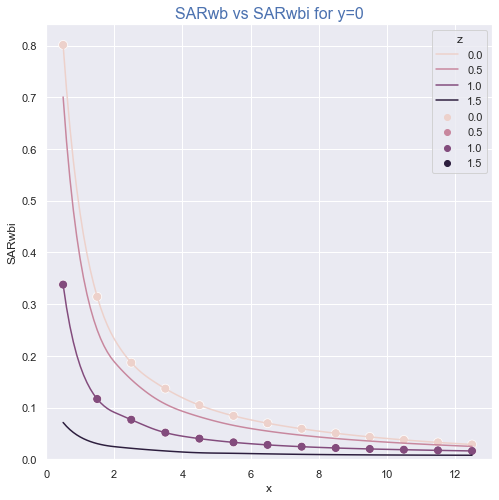

In [48]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(8, 8))
ym = 0
mask = (R.S.y == ym) & (R.S.z.isin([0,.5,1,1.5])) & (R.S.SARwbi != -100)

sn.lineplot(data=R.S[mask],x='x',y='SARwbi',hue='z')
sn.scatterplot(data=R.S[mask],x='x',y='SARwb',hue='z',s=80)
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_title(f'SARwb vs SARwbi for y={ym}', fontsize=16, color='b');

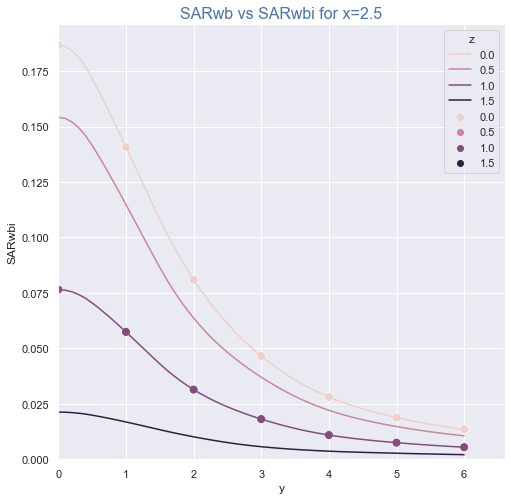

In [49]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(8, 8))
xm = 2.5
mask = (R.S.x == xm) & (R.S.z.isin([0,.5,1,1.5])) & (R.S.SARwbi != -100)

sn.lineplot(data=R.S[mask],x='y',y='SARwbi',hue='z')
sn.scatterplot(data=R.S[mask],x='y',y='SARwb',hue='z',s=80)
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_title(f'SARwb vs SARwbi for x={xm}', fontsize=16, color='b');

In [50]:
# Compare SAR, Smax & Ssa 1.6m 17pts
R.ExclusionZone(
    data=["Smax","Smax-1.6m-17","SARwbi"],
    power=[200] * 3,
    color=["white","blue", "magenta"],
    alpha=[0.6, 0.6, 0.6],
    setting=["public"] * 3,
    standard=["RPS S-1 WB"] * 3,
    title="Whole body SAR vs Smax vs Ssa compliance zones",
    figsize=(1200,600)
)

dat='Smax', con=1.8
dat='Smax-1.6m-17', con=1.8
dat='SARwbi', con=0.032
power = 80, plotpower = 200, setting = public, limit = 4.5 W/m², contour level = 1.800
power = 80, plotpower = 200, setting = public, limit = 4.5 W/m², contour level = 1.800
power = 80, plotpower = 200, setting = public, limit = 0.08 W/kg, contour level = 0.032


In [51]:
# Compare SAR & Ssa 1.6m 5pts
R.ExclusionZone(
    data=["Smax-1.6m-5","SARwbi"],
    power=[200] * 2,
    color=["blue", "magenta"],
    alpha=[0.6, 0.6],
    setting=["public"] * 2,
    standard=["RPS S-1 WB"] * 2,
    title="Whole body SAR vs Ssa compliance zones",
    figsize=(1200,600)
)

dat='Smax-1.6m-5', con=1.8
dat='SARwbi', con=0.032
power = 80, plotpower = 200, setting = public, limit = 4.5 W/m², contour level = 1.800
power = 80, plotpower = 200, setting = public, limit = 0.08 W/kg, contour level = 0.032


In [52]:
# Compare SAR & Ssa 1.5m 5pts
R.ExclusionZone(
    data=["Smax-1.5m-6","SARwbi"],
    power=[200] * 2,
    color=["blue", "magenta"],
    alpha=[0.6, 0.6],
    setting=["public"] * 2,
    standard=["RPS S-1 WB"] * 2,
    title="Whole body SAR vs Ssa compliance zones",
    figsize=(1200,600)
)

dat='Smax-1.5m-6', con=1.8
dat='SARwbi', con=0.032
power = 80, plotpower = 200, setting = public, limit = 4.5 W/m², contour level = 1.800
power = 80, plotpower = 200, setting = public, limit = 0.08 W/kg, contour level = 0.032


#### dB error histograms of Ssa vs WB SAR

In [23]:
RFcalcUC.Slimit(900,'pub','RPS S-1 WB')

4.5

IndexError: index 6 is out of bounds for axis 0 with size 6

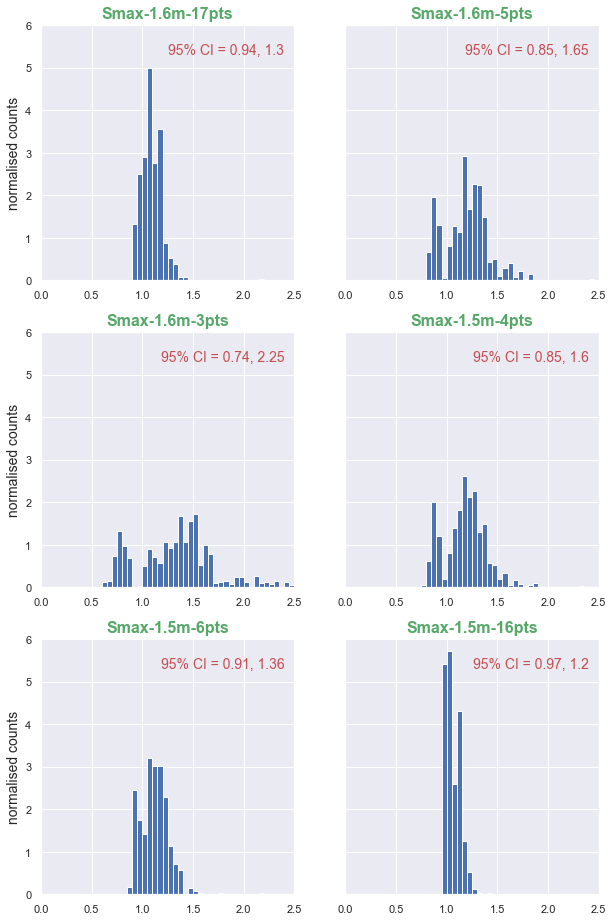

In [53]:
# Get histograms of limit normalised ratios of Smax vs WB SAR
Slim = 4.5
SARlim = 0.08
maskSARwb = ~R.S.SARwb.isna()
Ssalist = [s for s in R.datatitles.keys() if 'Smax-' in s]
nSa = len(Ssalist)

rows = nSa // 2
fig, axes = plt.subplots(rows,2,figsize=(10,16),sharey=True)
axes = axes.flatten()

bins = np.linspace(0,2.5,51)
for i, Ssa in enumerate(Ssalist):
    dBerr = (R.S.loc[maskSARwb,Ssa]/Slim) / (R.S.loc[maskSARwb,"SARwb"]/SARlim)
    axes[i].hist(dBerr,bins=bins,density=True)
    axes[i].set_title(Ssa + 'pts', fontsize=16, color='g',fontweight="bold")
    axes[i].set_xlim(bins[0],bins[-1])
    ci = np.percentile(dBerr,[2.5,97.5]).round(2)
    text = f'95% CI = {ci[0]}, {ci[1]}'
    axes[i].text(0.96, 0.9, text, horizontalalignment='right',
                 verticalalignment='center', transform=axes[i].transAxes,
                 fontsize=14, color='r')
    if i % 2 == 0:
        axes[i].set_ylabel('normalised counts',fontsize=14)
    if i in [6,7]:
        axes[i].set_xlabel('Limit normalised Ssa vs WB SAR ratio', fontsize=14)
        
title = 'Limit normalised ratios of spatial avg Smax vs WB SAR:   $\\frac{S_{sa}/S_{lim}}{SAR_{wb}/SAR_{lim}}$\n'
fig.suptitle(title, fontsize=20)
fig.tight_layout(h_pad=2)

fig.savefig('../plots/Ssa vs SARwb.png', dpi=100)   


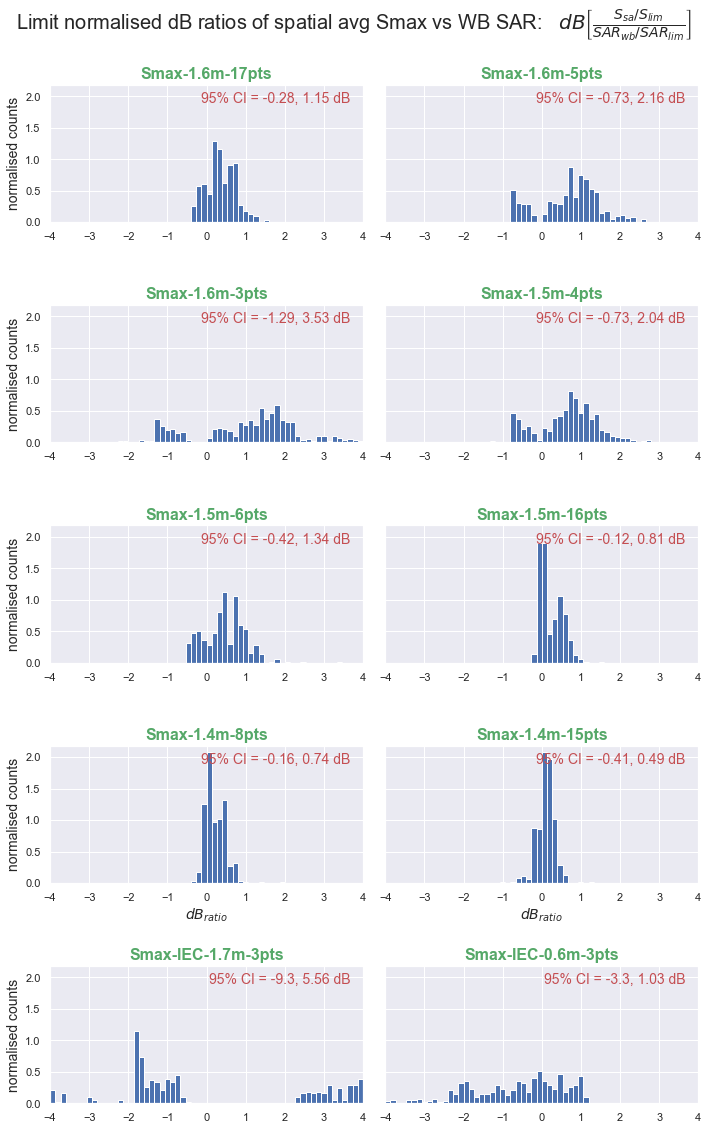

In [26]:
# Get histograms of limit normalised dB ratios of Smax vs WB SAR
Slim = 4.5
SARlim = 0.08
maskSARwb = ~R.S.SARwb.isna()
Ssalist = [s for s in R.datatitles.keys() if 'Smax-' in s]
nSa = len(Ssalist)

rows = nSa // 2
fig, axes = plt.subplots(rows,2,figsize=(10,16),sharey=True)
axes = axes.flatten()

bins = np.linspace(-4,4,61)
for i, Ssa in enumerate(Ssalist):
    dBerr = 10 * np.log10((R.S.loc[maskSARwb,Ssa]/Slim) / (R.S.loc[maskSARwb,"SARwb"]/SARlim))
    axes[i].hist(dBerr,bins=bins,density=True)
    axes[i].set_title(Ssa + 'pts', fontsize=16, color='g',fontweight="bold")
    axes[i].set_xlim(bins[0],bins[-1])
    ci = np.percentile(dBerr,[2.5,97.5]).round(2)
    text = f'95% CI = {ci[0]}, {ci[1]} dB'
    axes[i].text(0.96, 0.9, text, horizontalalignment='right',
                 verticalalignment='center', transform=axes[i].transAxes,
                 fontsize=14, color='r')
    if i % 2 == 0:
        axes[i].set_ylabel('normalised counts',fontsize=14)
    if i in [6,7]:
        axes[i].set_xlabel('$dB_{ratio}$', fontsize=14)
        
title = 'Limit normalised dB ratios of spatial avg Smax vs WB SAR:   $dB\\left[\\frac{S_{sa}/S_{lim}}{SAR_{wb}/SAR_{lim}}\\right]$\n'
fig.suptitle(title, fontsize=20)
fig.tight_layout(h_pad=2)

fig.savefig('../plots/dB Ssa vs SARwb.png', dpi=100)   


## Peak spatial fields

In [67]:
# Create S column for 1.6m and 2m peak spatial fields
R.peakspatial("Smax-ps-1.6m", "Smax", 17, title='peak spatial Smax over 1.6m')
R.peakspatial("Smax-ps-2m", "Smax", 21, title='peak spatial Smax over 2m')

creating Smax-ps-1.6m peak spatial values of Smax
creating Smax-ps-2m peak spatial values of Smax


In [70]:
# 3D view of point spatial, spatial avg and peak spatial public exclusions zones
R.ExclusionZone(
    data=["Smax","Smax-ps-1.6m"],
    power=[100]*3,
    color=["white", "green"],
    alpha=[1,0.8],
    setting=["public"]*3,
    standard=["RPS3"]*3,
    title="Point spatial vs peak spatial public exclusions zones",
    axv=(False,False,False),
    figsize=(1000,800),
    ycut=0,
)

power = 80, plotpower = 100, setting = public, limit = 4.5, contour level = 3.600
power = 80, plotpower = 100, setting = public, limit = 4.5, contour level = 3.600


## Steve hand checks

In [47]:
# Store Steve's assessment point coordinates
Point = namedtuple('Point', 'x y z')

points = [Point(x=2.5, y=2, z=-1),
          Point(x=3.5, y=0, z=-2),
          Point(x=4.5, y=1, z=0),
          Point(x=5.5, y=0, z=0)]

In [48]:
# Generate dataframe of my S values at Steve's validation points
pmask = np.zeros(len(R.S))
for p in points:
    pmask = pmask | ((R.S.x == p.x) & (R.S.y == p.y) & (R.S.z == p.z))
    
dfv = R.S.loc[pmask].copy()    # validation data
dfv.columns.name = 'Vitas results'
dfv.index = ('pt1','pt2','pt3','pt4')
cols = ('x','y','z','SE','SH','Smax','SARwb',
        'Smax-1.6m-5','Smax-1.5m-6')
dfv = dfv.filter(items=cols,axis=1)

# Calculate normalised values
Slim = RFcalcUC.Slimit(900, setting='public', standard='RPS S-1 WB')
SARlim = 0.08
for col in dfv.columns[-2:]:
    newcol = col + ' (limit normalised)'
    dfv[newcol] = (dfv[col] / Slim) / (dfv.SARwb / SARlim)
    
dfv.T.round(3)

,pt1,pt2,pt3,pt4
Vitas results,,,,
x,2.500,3.500,4.500,5.500
y,2.000,0.000,1.000,0.000
z,-1.000,-2.000,0.000,0.000
SE,0.749,0.122,8.019,7.037
SH,0.710,0.125,8.113,7.108
Smax,0.749,0.125,8.113,7.108
SARwb,0.030,0.003,0.094,0.084
Smax-1.6m-5,2.158,0.228,4.569,3.954
Smax-1.5m-6,1.884,0.195,4.859,4.229


## Stuart hand checks

In [45]:
# Store Stuart's assessment point coordinates
Point = namedtuple('Point', 'x y z')

points = [Point(0.5, -3, -2),
          Point(6.5, -5, 1),
          Point(8.5, 0, 0),
          Point(12.5, -1, -1)]

In [46]:
# Generate dataframe of my S values at Stuart's validation points
pmask = np.zeros(len(R.S))
for p in points:
    pmask = pmask | ((R.S.x == p.x) & (R.S.y == p.y) & (R.S.z == p.z))
    
dfv = R.S.loc[pmask].copy()    # validation data
dfv.columns.name = 'Vitas results'
dfv.index = ('pt1','pt2','pt3','pt4')
cols = ('x','y','z','SE','SH','Smax','SARwb',
        'Smax-1.6m-5','Smax-1.5m-6')
dfv = dfv.filter(items=cols,axis=1)

# Calculate normalised values
Slim = RFcalcUC.Slimit(900, setting='public', standard='RPS S-1 WB')  # W/m²
SARlim = 0.08  # W/kg
for col in dfv.columns[-2:]:
    newcol = col + ' (limit normalised)'
    dfv[newcol] = (dfv[col] / Slim) / (dfv.SARwb / SARlim)
    
dfv.round(4)

Vitas results,x,y,z,SE,SH,Smax,SARwb,Smax-1.6m-5,Smax-1.5m-6,Smax-1.6m-5 (limit normalised),Smax-1.5m-6 (limit normalised)
pt1,0.5,-3.0,-2.0,0.0295,0.0309,0.0309,0.0004,0.0379,0.0302,1.4966,1.1923
pt2,6.5,-5.0,1.0,0.4841,0.4795,0.4841,0.0130,0.8454,0.8671,1.1587,1.1885
pt3,8.5,0.0,0.0,3.7178,3.7393,3.7393,0.0504,2.4719,2.6316,0.8726,0.9290
pt4,12.5,-1.0,-1.0,0.8514,0.8516,0.8516,0.0154,0.9210,0.8651,1.0619,0.9973


## Thors $SAR_{10g}$ and $SAR_{wb}$ calcs

In [27]:
def calcSAR10g(f,P,N,L,Φdeg,D0dBi,rlist):
    # constants
    A = 3 / 2
    B = 1
    π = np.pi
    λ = f / 300

    # convert Φ and D0 to correct units
    Φ = Φdeg * π / 180  # radians
    D0 = 10**(D0dBi/10) # linear

    # calculate r10g breakpoints
    r10g1 = λ / 4
    r10g2 = (Φ / 12) * D0 * L

    # Calculate SARlocal
    def cSAR10g(r):
        if r < r10g1:
            SAR10g = A * B * P / (N * r10g1)
        elif r <= r10g2:
            SAR10g = B * P / (N * Φ * r)
        else:
            SAR10g = B * P * r10g2 / (N * Φ * r**2)
        return SAR10g

    SAR10glist = list(map(cSAR10g,rlist))
    return SAR10glist   

def calcSARwb(f,P,Φdeg,D0dBi,rlist):
    # constants
    C = 1 / 75
    D = 1 / 200
    E = 8E8
    F = 2 / 5
    π = np.pi
    λ = f / 300

    # convert Φ and D0 to correct units
    Φ = Φdeg * π / 180  # radians
    D0 = 10**(D0dBi/10) # linear

    # calculate rwb breakpoints
    rwb1 = D / (C * Φ)
    if 800 <= f < 2000:
        rwb2 = E * D0 * Φ / (π * f * 1E6)
    elif 2000 <= f <= 2200:
        rwb2 = F * D0 * Φ / π
    else:
        raise NameError(f'f ({f}) must be between 800 and 2200 MHz')

    # Calculate SARwb
    def cSARwb(r):
        if r < rwb1:
            SARwb = C * P
        elif r <= rwb2:
            SARwb = D * P / (Φ * r)
        else:
            SARwb = D * P * rwb2 / (Φ * r**2)
        return SARwb

    SARwblist = list(map(cSARwb,rlist))
    return(SARwblist)

In [28]:
# Test out the SAR functions
f = 900  # MHz
P = 80   # W
N = 9
L = 2.25 # m
Φdeg = 68 # degrees
D0dBi = 17  # dBi
xlist = np.array([0.5,1,2,3,4,5])
rlist = xlist - 0.04

SAR10glist = calcSAR10g(f,P,N,L,Φdeg,D0dBi,rlist)
SARwblist = calcSARwb(f,P,Φdeg,D0dBi,rlist)
pd.DataFrame(dict(x=xlist,r=rlist,SAR10g=SAR10glist,SARwb=SARwblist))

,x,r,SAR10g,SARwb
0,0.5,0.46,17.777778,0.732683
1,1.0,0.96,7.801713,0.351077
2,2.0,1.96,3.821247,0.171956
3,3.0,2.96,2.530285,0.113863
4,4.0,3.96,1.891324,0.085110
5,5.0,4.96,1.510009,0.067950


## IEC 62232 SAR calcs

See section **B.4.2.2** of the IEC 62232 standard (2018 Standards Australia adoption)

Also see: M. C. Gosselin et al., “Estimation formulas for the specific absorption rate in humans exposed to base-station antennas,” *IEEE Trans. Electromagn. Compat.*, vol. 53, no. 4, 2011.

### IEC SAR formula function

In [1]:
import math

def SAR_IEC_front(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg):
    '''This function calculates upper bound estimates of local 1g, 10g and whole body average
       SAR induced by exposure in front of a directional (vertical or cross polarized) or
       omni antenna for frequencies 300 to 5000 MHz in accordance with the SAR formulas
       in section B.4.2.2 in the IEC 62232 (2018) standard.
       The driven elements of the antenna must lie on the same vertical axis so it is generally
       only suitable for MBS omni and panel antennas
       
       Inputs:
          d = closest distance between the outermost point of the antenna and 
              a box enclosing the body
       body = body type for SAR calculations ("adult" or "child")
       fMHz = frequency of the exposure (MHz)
          P = radiated power of the antenna in (W)
          N = Number of driven elements
       DdBi = peak directivity of the antenna (dBi)
          L = overall height of the antenna (m)
       Φdeg = horizontal half-power beamwidth (degrees) of the antenna
       Θdeg = vertical half-power beam width (degrees) of the antenna
       
       Outputs:
         SARwb, SAR10g, SAR1g (W/kg)       
    '''
    # Constants
    π = math.pi
    nan = math.nan  # nan = not a number
    λ = 300 / fMHz
    
    # check inputs
    assert 300 <= fMHz <= 5000, f'fMHz ({fMHz} MHz) must lie within range 300 to 5000 MHz'
    assert body in ['adult','child'], f'body ({body}) must be either "adult" or "child"'
    assert 0.1 < L < 3, f'value for L ({L} m) does not look right'
    assert 1 <= N <= 15, f'value for N ({N}) does not look right'
    assert 10 < Φdeg <= 360, f'Φdeg ({Φdeg}°) should lie within range 10 to 360 degrees'
    assert 4 < Θdeg <= 180, f'Θdeg ({Φdeg}°) should lie within range 4 to 180 degrees'
        
    # Convert DdBi to linear gain
    D = 10**(DdBi/10) # linear

    # convert Φdeg and Θdeg to radians
    Φ = Φdeg * π / 180
    Θ = Θdeg * π / 180
    
    # calculate Hbeam
    Hbeam = 2 * d * math.tan(Θ/2)
    
    # Set A and B
    A, B = (0.089, 1.54) if body.lower() == 'adult' else (0.06, 0.96)
    
    # Calculate Rwb10g, Rwb1g
    Rwb10g, Rwb1g = (1.5,0.6) if fMHz <= 2500 else (1,0.3)
        
    # calculate Heff
    if L >= B:
        Heff = B
    else:
        if Hbeam < L and Hbeam < B:
            Heff = L
        elif L <= Hbeam < B:
            Heff = Hbeam
        elif Hbeam >= B:
            Heff = B

    # Calculate C(f)
    dmm = d * 1000  # convert d from m to mm
    if fMHz <= 900:
        if dmm < 200:
            C = nan
        elif dmm <= 400:
            C = (3.5 + (fMHz-300)/600 ) * (1 + 0.8*dmm/400)
        else:
            C = 6.3 + (fMHz-300)/600 * 1.8
    else:
        if dmm <= 400:
            C = 4.5 * (1 + 0.8*dmm/400)
        else:
            C = 8.1
    C = C * 1E-4
    
    # Calculate whole body average SAR
    if d > λ/(2*π):
        SARwb  = C*Heff*P / (A*B*Φ*L*d) * (1 + ((4*π*d) / (Φ*D*L))**2)**-0.5
    else:
        SARwb = nan
        
    # Calculate 10g, 1g localised SAR
    if d >= 0.2:
        SAR10g = 25 * SARwb * B / (Heff * Rwb10g)
        SAR1g  = 20 * SARwb * B / (Heff * Rwb1g)
    else:
        SAR10g, SAR1g = nan, nan
        
    return d, SARwb, SAR10g, SAR1g, Hbeam, Heff, C

### Test out the IEC 62232 SAR function

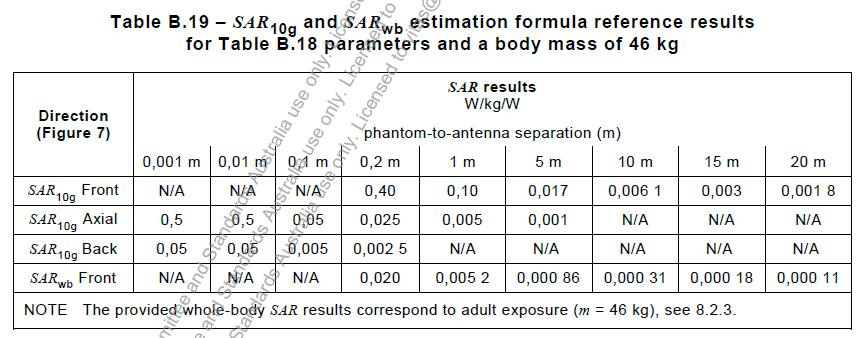

In [2]:
# IEC 62232 2018 validation values
dlist = [0.001,0.01,0.1,0.2,1,5,10,15,20]
body = 'adult'
fMHz = 900  # MHz
P = 1   # W
N = 10
DdBi = 18
L = 1.3  # m
Φdeg = 65   # horizontal HPBW in degrees
Θdeg = 6.5  # vertical HPBW in degress

print('     d      SARwb    SAR10g     SAR1g     Hbeam  Heff         C')
for d in dlist:
    d,SARwb,SAR10g,SAR1g,Hbeam,Heff,C = SAR_IEC_front(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg)
    print(f'{d:6.3g}{SARwb:11.3g}{SAR10g:10.3g}{SAR1g:10.3g}{Hbeam:10.3g}{Heff:6.3g}{C:10.6f}')

     d      SARwb    SAR10g     SAR1g     Hbeam  Heff         C
 0.001        nan       nan       nan  0.000114   1.3       nan
  0.01        nan       nan       nan   0.00114   1.3       nan
   0.1        nan       nan       nan    0.0114   1.3       nan
   0.2     0.0203       0.4       0.8    0.0227   1.3  0.000630
     1    0.00516     0.102     0.204     0.114   1.3  0.000810
     5   0.000863     0.017    0.0341     0.568   1.3  0.000810
    10    0.00031   0.00612    0.0122      1.14   1.3  0.000810
    15   0.000182   0.00304   0.00607       1.7  1.54  0.000810
    20   0.000107   0.00179   0.00357      2.27  1.54  0.000810


### Get the FEKO antenna pattern files

In [18]:
horiz_pattern_file = 'IEC-62232-panel-antenna_horCutFF.ffe'
vert_pattern_file = 'IEC-62232-panel-antenna_verCutFF.ffe'
Enames2 = ["theta","phi","Re_Etheta","Im_Etheta","Re_Ephi","Im_Ephi","directivity_theta","directivity_phi","directivity_total"]
hpat = pd.read_csv(datadir + horiz_pattern_file, sep='\s+', skiprows=17, names=Enames2)
vpat = pd.read_csv(datadir + vert_pattern_file, sep='\s+', skiprows=17, names=Enames2)
vpat.head(100)

,theta,phi,Re_Etheta,Im_Etheta,Re_Ephi,Im_Ephi,directivity_theta,directivity_phi,directivity_total
0,1.0,0.0,-0.279353,0.691228,0.000622,0.000009,-43.339357,-104.912728,-43.339354
1,2.0,0.0,-0.549998,1.405080,0.000629,-0.000007,-37.215657,-104.808904,-37.215657
2,3.0,0.0,-0.810747,2.142264,0.000641,-0.000027,-33.590024,-104.640319,-33.590024
3,4.0,0.0,-1.060630,2.903073,0.000657,-0.000052,-30.987515,-104.408517,-30.987515
4,5.0,0.0,-1.298848,3.687058,0.000677,-0.000081,-28.947174,-104.116070,-28.947174
5,6.0,0.0,-1.524726,4.492647,0.000700,-0.000115,-27.265309,-103.766713,-27.265309
6,7.0,0.0,-1.737667,5.316726,0.000727,-0.000154,-25.835159,-103.365387,-25.835159
7,8.0,0.0,-1.937110,6.154202,0.000757,-0.000199,-24.595098,-102.918160,-24.595098
8,9.0,0.0,-2.122480,6.997546,0.000789,-0.000249,-23.507659,-102.432051,-23.507659
9,10.0,0.0,-2.293147,7.836326,0.000824,-0.000305,-22.549729,-101.914756,-22.549729


### Check Danie's WB SAR calcs against IEC SAR formula

,x,SARwb,d,SARwb_IEC,ratio
0,0.5,0.80114,0.44,0.440606,1.818
1,1.5,0.31427,1.44,0.146042,2.152
2,2.5,0.18681,2.44,0.086658,2.156
3,3.5,0.13660,3.44,0.060904,2.243
4,4.5,0.10464,4.44,0.046393,2.255
5,5.5,0.08401,5.44,0.037026,2.269
6,6.5,0.06978,6.44,0.030456,2.291
7,7.5,0.05899,7.44,0.025587,2.305
8,8.5,0.05036,8.44,0.021837,2.306
9,9.5,0.04331,9.44,0.018866,2.296


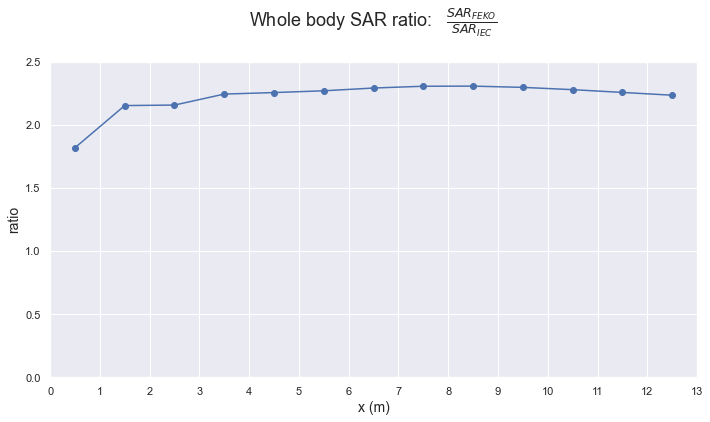

In [27]:
# Set the SAR input parameters
body = 'adult'
fMHz = 900  # MHz
P = 80   # W
N = 9
DdBi = 17.03
L = 2.25  # m
Φdeg = 84.1   # horizontal HPBW in degrees (from Danie's chart)
Θdeg = 8.28   # vertical HPBW in degress (from Danie's chart)

# Get Danie's WB SAR values along x axis
mask = ~R.S.SARwb.isna() & (R.S.z == 0) & (R.S.y == 0)
SARdf = R.S.loc[mask, ['x','SARwb']]

# Set d values
# Reduce d by 0.1m to shift evaluation point to front of body
# Increase d by 0.04m to push origin back to antenna phase centre at centre of reflector
SARdf['d'] = SARdf.x - 0.1 + 0.04
d = SARdf.d.values

def IECwbSAR(d):
    d, SARwb, SAR10g, SAR1g, Hbeam, Heff, C = SAR_IEC_front(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg)
#     return pd.Series(dict(SARwb_IEC=SARwb,d=d,Hbeam=Hbeam,Heff=Heff,C=C)).astype(float)
    return pd.Series(dict(SARwb_IEC=SARwb)).astype(float)

results = SARdf.x.apply(IECwbSAR)
SARdf = pd.concat([SARdf,results], axis=1).reset_index(drop=True)
SARdf['ratio'] = (SARdf.SARwb / SARdf['SARwb_IEC']).round(3)
# SARdf['dBerr'] = (10. * np.log10(SARdf.ratio)).round(2)
display(SARdf)
SARdf.to_clipboard()

# Draw plot of ratio
plt.figure(figsize=(10,6))
plt.plot(SARdf.x, SARdf.ratio,'-o')
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('ratio',fontsize=14)
plt.xlim(0,13)
plt.xticks(range(0,14))
plt.ylim(0,2.5)
plt.title('Whole body SAR ratio:   $\\frac{SAR_{FEKO}}{SAR_{IEC}}$\n',fontsize=18)
plt.tight_layout(pad=1);

## Draw my own compliance plots

Coordinate center is in the middle of the reflector plate.

Note that coordinate centre for SAR calcs is from the middle of the centre feed, which is **0.04 m** in front of the reflector plate

Antenna radiated power level is set to **200W**

In [37]:
# input data
f = 900  # MHz
P = 200  # W
N = 9
L = 2.25 # m
Φdeg = 68 # degrees
D0dBi = 17  # dBi
xlist = np.arange(0.5,5.1,0.1).round(1)
rlist = xlist - 0.04

# Calculate SAR10g and SARwb
SAR10glist = calcSAR10g(f,P,N,L,Φdeg,D0dBi,rlist)
SARwblist = calcSARwb(f,P,Φdeg,D0dBi,rlist)
SAR = pd.DataFrame(dict(x=xlist,r=rlist,SAR10g=SAR10glist,SARwb=SARwblist))

# Extract Smax spatial averages
# Scols = ['Smax-2m-3','Smax-2m-5','Smax-2m-11','Smax-2m-21']
Scols = ['Smax-1.6m-3','Smax-1.6m-5','Smax-1.6m-17']
mask = R.S.x.isin(xlist) & (R.S.y==0) & (R.S.z==0)
Sspat = R.S.loc[mask,['x'] + Scols]

# Merge the SAR and Sspat data
df = SAR.merge(Sspat,on='x')

# Create compliance ratios for occ exposure
SAR10glim = 10  # W/kg
SARwblim = 0.4  # W/kg
Swblim = 22.5   # W/m²
df['SAR10g (Thors)'] = df.SAR10g / SAR10glim
df['SARwb (Thors)'] = df.SARwb / SARwblim
df[Scols] = df[Scols] / Swblim
newcols = {s:R.datatitles[s].split('(')[1][:-1].replace(' points averaged','pts') for s in Scols}
df = df.rename(columns=newcols)

df.round(3).head()

,x,r,SAR10g,SARwb,3pts over 1.6m,5pts over 1.6m,17pts over 1.6m,SAR10g (Thors),SARwb (Thors)
0,0.5,0.46,44.444,1.832,5.435,5.822,5.920,4.444,4.579
1,0.6,0.56,44.444,1.505,4.315,4.504,4.901,4.444,3.762
2,0.7,0.66,44.444,1.277,3.511,3.640,4.225,4.444,3.192
3,0.8,0.76,24.637,1.109,3.017,3.118,3.714,2.464,2.772
4,0.9,0.86,21.772,0.980,2.743,2.841,3.292,2.177,2.449


In [38]:
df1 = df.drop(columns=['r','SAR10g','SARwb']).copy()
cols = df1.columns[1:]
df1[cols] = df1[cols] * 100

# Plot data
fig, ax = plt.subplots(figsize=(11,7))
for col in cols:
    if 'SAR' in col:
        ax.plot(df1.x, df1[col], lw=2, label=col)
    else:
        ax.plot(df1.x, df1[col], ls='--',label=col)

ax.set_xlim(0,5)
ax.set_ylim(0,500)
ax.set_xticks(np.arange(0,5.5,.5))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}%')) # No decimal places
ax.set_xlabel('separation distance (m)',fontsize=16)
ax.set_ylabel('Level of compliance with RPS S-1',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_title("% RPS S-1 compliance curves for IEC 62232 panel antenna (boresight)",
             fontsize=18,color='blue')
ax.legend(fontsize=16,facecolor='white')
# fig.savefig('RPS S-1 compliance curves (2m).png',dpi=300)
fig.savefig('RPS S-1 compliance curves (1.6m).png',dpi=300)


## Body rotation SAR data

### Import and process data

In [16]:
# Import Danie's SAR data spreadsheet
xlfile = datadir + 'wbSAR-rotated-model-investigation.xlsx'
brSAR = pd.read_excel(xlfile)
brSAR

,x,y,z,location,angle,SAR
0,1,0,0,near-field bore-sight,0,0.46132
1,1,0,0,near-field bore-sight,45,0.34362
2,1,0,0,near-field bore-sight,90,0.25969
3,1,0,0,near-field bore-sight,135,0.33280
4,1,0,0,near-field bore-sight,180,0.41869
5,1,0,0,near-field bore-sight,225,0.33280
6,1,0,0,near-field bore-sight,270,0.25969
7,1,0,0,near-field bore-sight,315,0.34362
8,1,1,0,near-field 45° azimuth,0,0.12628
9,1,1,0,near-field 45° azimuth,45,0.16214


In [21]:
# Calculate dBSAR relative to the geometric mean of each location group
brSAR['dBSAR'] = brSAR.groupby('location')['SAR'].transform(lambda x: 10 * np.log10(x / stats.mstats.gmean(x)))

# Adjust angle for 45° locations so that 0° is defined as facing the antenna
mask = brSAR.location.str.contains('45')
brSAR['antenna angle'] = brSAR.angle.where(~mask,(brSAR.angle - 45) % 360)
brSAR2 = brSAR.drop(columns='angle')
brSAR2['dBSAR'] = brSAR2.dBSAR.round(2)
brSAR2.sort_values(['location','antenna angle'])

,x,y,z,location,SAR,dBSAR,antenna angle
25,34,34,0,far-field 45° azimuth,0.00108,1.42,0
26,34,34,0,far-field 45° azimuth,0.00080,0.12,45
27,34,34,0,far-field 45° azimuth,0.00058,-1.28,90
28,34,34,0,far-field 45° azimuth,0.00076,-0.11,135
29,34,34,0,far-field 45° azimuth,0.00101,1.13,180
30,34,34,0,far-field 45° azimuth,0.00076,-0.11,225
31,34,34,0,far-field 45° azimuth,0.00058,-1.28,270
24,34,34,0,far-field 45° azimuth,0.00080,0.12,315
16,34,0,0,far-field bore-sight,0.00468,1.42,0
17,34,0,0,far-field bore-sight,0.00344,0.09,45


### Draw plots of SAR

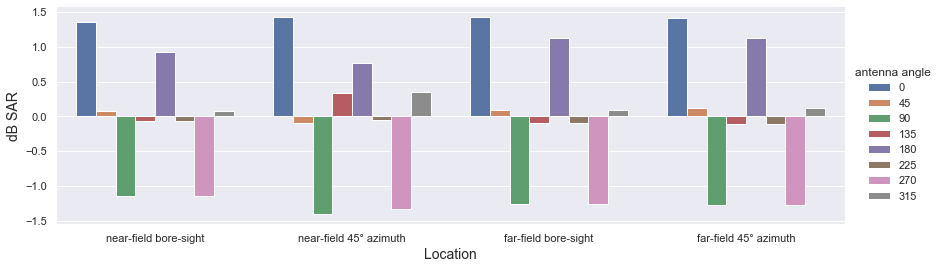

In [25]:
chart = sn.catplot(x="location", y="dBSAR", hue="antenna angle", 
                   kind="bar",height=4,aspect=3,data=brSAR)
ax = chart.axes[0][0]
ax.set_ylabel("dB SAR",fontsize=14)
ax.set_xlabel("Location",fontsize=14)
plt.subplots_adjust(bottom=0.2,left=0.07)

plotfile = plotdir + 'dBSAR vs location.png'
plt.savefig(plotfile,dpi=150)


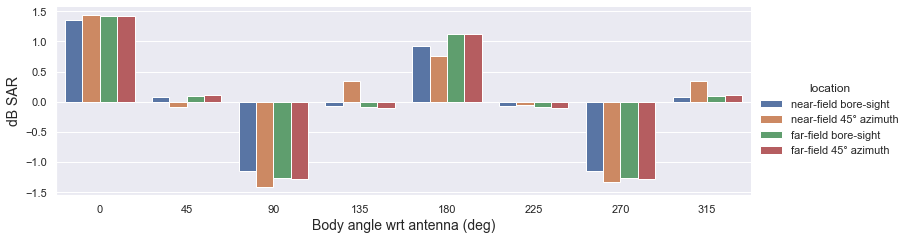

In [26]:
chart = sn.catplot(x="antenna angle", y="dBSAR", hue="location", 
                   kind="bar",height=3.5,aspect=3,data=brSAR)
ax = chart.axes[0][0]
ax.set_ylabel("dB SAR",fontsize=14)
ax.set_xlabel("Body angle wrt antenna (deg)",fontsize=14)
plt.subplots_adjust(bottom=0.2)

plotfile = plotdir + 'dBSAR vs antenna angle.png'
plt.savefig(plotfile,dpi=150)

### Create 0 angle dataframe 

In [27]:
# Create dataframe for antenna angle == 0
mask = brSAR['antenna angle'] == 0
br0SAR = brSAR[mask].drop(columns=['angle','antenna angle']).copy()
br0SAR

,x,y,z,location,SAR,dBSAR
0,1,0,0,near-field bore-sight,0.46132,1.350862
9,1,1,0,near-field 45° azimuth,0.16214,1.433666
16,34,0,0,far-field bore-sight,0.00468,1.422867
25,34,34,0,far-field 45° azimuth,0.00108,1.418727


In [28]:
# Check mean and std dev statistics of dBSAR
drop_cols = ['angle','antenna angle','SAR']
dBSARstats = brSAR.drop(columns=drop_cols).groupby('location').agg(mean_dBSAR=('dBSAR',np.mean),stdev_dBSAR=('dBSAR',np.std))
dBSARstats

,mean_dBSAR,stdev_dBSAR
location,,
far-field 45° azimuth,-1.221245e-15,0.972280
far-field bore-sight,8.361367e-16,0.965603
near-field 45° azimuth,-1.637579e-15,0.975555
near-field bore-sight,5.308254e-16,0.872507


**Note that the mean of dBSAR is ~ 0 as expected since we used a geometric mean**

In [29]:
# Merge in stats data with br0SAR dataframe
br0SAR = br0SAR.merge(dBSARstats['stdev_dBSAR'],left_on='location',right_index=True)
br0SAR

,x,y,z,location,SAR,dBSAR,stdev_dBSAR
0,1,0,0,near-field bore-sight,0.46132,1.350862,0.872507
9,1,1,0,near-field 45° azimuth,0.16214,1.433666,0.975555
16,34,0,0,far-field bore-sight,0.00468,1.422867,0.965603
25,34,34,0,far-field 45° azimuth,0.00108,1.418727,0.972280


### Compare public SAR compliance to public spatially averaged S compliance


In [54]:
# Get limit levels for S and SAR
Slim = RFcalcUC.Slimit(900, setting='public', standard='RPS S-1 WB')
SARlim = 0.08

# Calc SAR compliance
br0SAR['SAR compliance'] = br0SAR.SAR / SARlim

# Calc S compliance
br0SAR[['x','y','z']] = br0SAR[['x','y','z']].astype('float') # convert xyz cols to float for merging with R.S
br0 = br0SAR.merge(R.S) 
scols = br0.filter(regex='^SE|^Smax|^SH',axis=1).columns # get S columns
br0[scols] = br0[scols] / Slim
br0 = br0.set_index('location',drop=True)
br0.T

location,near-field bore-sight,near-field 45° azimuth
x,1.000000,1.000000
y,0.000000,1.000000
z,0.000000,0.000000
SAR,0.461320,0.162140
dBSAR,1.350862,1.433666
stdev_dBSAR,0.872507,0.975555
SAR compliance,5.766500,2.026750
r,1.000000,1.414214
phi,0.000000,45.000000
SE,8.564153,2.928756


## Scratch

In [40]:
df1.reindex

,x,y,z,p
0,0.5,0.0,-2.0,-1.5
1,0.5,0.0,-1.0,-0.5
2,0.5,0.0,0.0,0.5
3,0.5,0.0,1.0,1.5
4,0.5,0.0,2.0,2.5
5,0.5,1.0,-2.0,-0.5
6,0.5,1.0,-1.0,0.5
7,0.5,1.0,0.0,1.5
8,0.5,1.0,1.0,2.5
9,0.5,1.0,2.0,3.5


In [11]:
RFcalcUC.SARlimit('occi')

0.4

In [12]:
dat = 'SARwb'
'SAR' in dat

True

In [13]:
xx= []
xx.append(3)
xx

[3]

In [10]:
hman = 1
type(hman)

int